In [1]:
!pip install matplotlib
!pip install scipy
#this notebook is to implement the ResNet without any extra operation to prevent overfitting
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


import keras
from keras import Model
import keras.layers as layers
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import image_dataset_from_directory, Sequence
from keras.preprocessing.image import ImageDataGenerator

from keras import datasets
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-03-22 02:25:43.562106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 02:25:43.725282: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 02:25:44.465238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-22 02:25:44.465356: W tensorflow/

In [2]:
img_train_path = os.path.join("DATASET","TRAIN")
img_test_path = os.path.join("DATASET","TEST")
img_SET1_path = os.path.join("DATASET","CROSS/SET1")
img_SET2_path = os.path.join("DATASET","CROSS/SET2")
img_SET3_path = os.path.join("DATASET","CROSS/SET3")
img_SET1_SET2_path = os.path.join("DATASET","CROSS/SET1_SET2")
img_SET1_SET3_path = os.path.join("DATASET","CROSS/SET1_SET3")
img_SET2_SET3_path = os.path.join("DATASET","CROSS/SET2_SET3")

#with ImageDataGenerator, we can rescale the images, fill mode allow us to shuffle the dataset
data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
BATCH_SIZE = 128

#generate dictionary iterator, they can be used for training, validation and test
raw_generator = data_gen.flow_from_directory(img_train_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET1_generator = data_gen.flow_from_directory(img_SET1_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET2_generator = data_gen.flow_from_directory(img_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET3_generator = data_gen.flow_from_directory(img_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET1_generator = data_gen.flow_from_directory(img_SET1_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET2_generator = data_gen.flow_from_directory(img_SET1_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET3_generator = data_gen.flow_from_directory(img_SET2_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
test_generator = data_gen.flow_from_directory(img_test_path, target_size=(256,256), batch_size=BATCH_SIZE)

Found 22564 images belonging to 2 classes.
Found 7447 images belonging to 2 classes.
Found 7672 images belonging to 2 classes.
Found 7445 images belonging to 2 classes.
Found 15119 images belonging to 2 classes.
Found 14892 images belonging to 2 classes.
Found 15117 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [3]:
#show the image size, 128 means batch size, 256x256 is image size, 3 is RGB
img, _= next(raw_generator)
print(img.shape)

(128, 256, 256, 3)


In [4]:
def rebuild_model():
    #set models to global, so then can be called
    global pretrained_model
    global model
    #import pre-trained model
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
    #all layers trainable
    #build our own model attach to pre-trained model
    model = keras.Sequential()

    model.add(pretrained_model)
    
    #flatten layter to make the features into only 1 dimension, then can be received by the dense layer
    model.add(Flatten())
    #dense layers with relu activation
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    #output layer
    model.add(Dense(2, activation='softmax'))
    #compile model, with Adam optimizer, loss function is categorical_crossentropy
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=True)
rebuild_model()
#display the architecture of ResNet
pretrained_model.summary()

2023-03-22 02:25:47.968691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 02:25:48.017209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 02:25:48.017429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 02:25:48.019636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 02:25:48.019795: I tensorflow/compiler/xla/stream_executo

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [5]:
# early stopping, reduce time and overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#display the whole model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,801,282
Trainable params: 24,748,162
No

Epoch 1/25


2023-03-22 01:29:59.498620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-22 01:30:08.664601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 01:30:08.799820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
 

2023-03-22 01:30:09.833028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 512 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 2048 input_feature_map_count: 512 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 01:30:09.854146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 2048 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 2048 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an id

 94/118 [======================>.......] - ETA: 7s - loss: 0.3558 - accuracy: 0.8725

2023-03-22 01:30:58.372203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 01:30:58.390216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

2023-03-22 01:30:58.582877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 256 spatial: 16 16  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 1024 input_feature_map_count: 256 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 01:30:58.599798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 128 spatial: 32 32  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 128 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an id

118/118 [==============================] - 108s 619ms/step - loss: 0.3366 - accuracy: 0.8791 - val_loss: 0.7895 - val_accuracy: 0.4433
Epoch 2/25
118/118 [==============================] - 50s 426ms/step - loss: 0.2386 - accuracy: 0.9099 - val_loss: 3.1833 - val_accuracy: 0.4436
Epoch 3/25
118/118 [==============================] - 50s 422ms/step - loss: 0.1935 - accuracy: 0.9281 - val_loss: 1.1369 - val_accuracy: 0.4433
Epoch 4/25
118/118 [==============================] - 51s 427ms/step - loss: 0.1620 - accuracy: 0.9398 - val_loss: 1.7402 - val_accuracy: 0.4426
Epoch 5/25
118/118 [==============================] - 51s 433ms/step - loss: 0.1459 - accuracy: 0.9434 - val_loss: 2.0847 - val_accuracy: 0.4428
Epoch 6/25
118/118 [==============================] - 52s 437ms/step - loss: 0.1380 - accuracy: 0.9480 - val_loss: 1.0204 - val_accuracy: 0.5598
Epoch 7/25
118/118 [==============================] - 50s 421ms/step - loss: 0.1038 - accuracy: 0.9602 - val_loss: 0.9018 - val_accuracy: 0.

2023-03-22 01:49:30.671632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 01:49:30.760167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

20/20 [==============================] - 8s 390ms/step - loss: 0.3655 - accuracy: 0.8942
test loss, test acc: [0.3655453324317932, 0.89415043592453]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


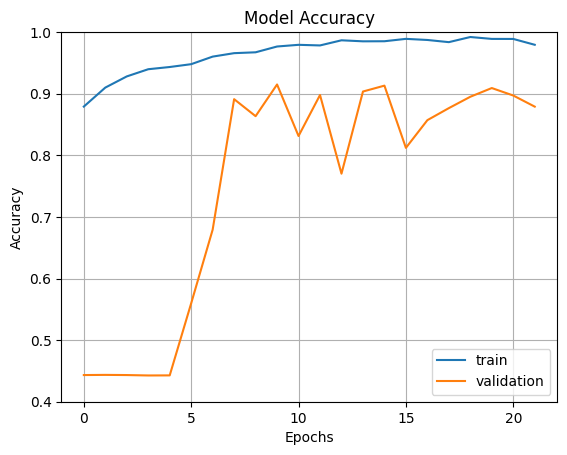

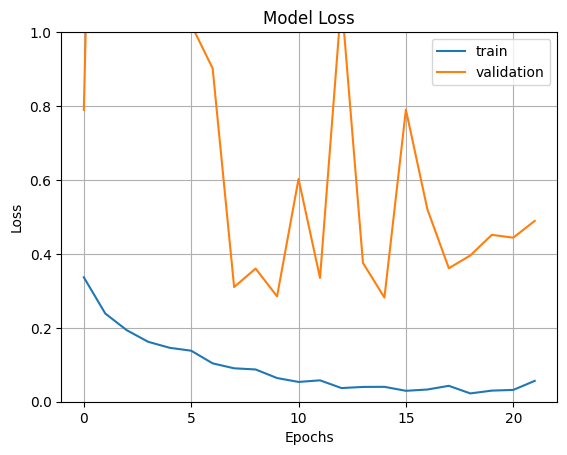

In [6]:
#for cross-validation, for this time, Set1 and Set2 is training dataset, Set3 is validation dataset
train_generator = CSET1_generator
validation_generator = SET3_generator

#build a new model
rebuild_model()

#set steps for training and validation, it can prevent sometimes notebook stop working
steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

#evaluate our model on the unseen dataset
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

#plot accuracy and loss
fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/25


2023-03-22 02:26:10.803973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-22 02:26:20.200386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 02:26:20.338007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
 

2023-03-22 02:26:21.381042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 512 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 2048 input_feature_map_count: 512 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 02:26:21.402655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 2048 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 2048 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an id

 95/116 [=======================>......] - ETA: 6s - loss: 0.3182 - accuracy: 0.8799

2023-03-22 02:27:11.396773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 02:27:11.445424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

2023-03-22 02:27:11.839096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 512 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 2048 input_feature_map_count: 512 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 02:27:11.848796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 2048 spatial: 8 8  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 2048 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an iden

116/116 [==============================] - 111s 653ms/step - loss: 0.3076 - accuracy: 0.8851 - val_loss: 1.5650 - val_accuracy: 0.4424
Epoch 2/25
116/116 [==============================] - 50s 427ms/step - loss: 0.2280 - accuracy: 0.9117 - val_loss: 2.5459 - val_accuracy: 0.4441
Epoch 3/25
116/116 [==============================] - 50s 428ms/step - loss: 0.1932 - accuracy: 0.9289 - val_loss: 1.1830 - val_accuracy: 0.4473
Epoch 4/25
116/116 [==============================] - 50s 426ms/step - loss: 0.1696 - accuracy: 0.9367 - val_loss: 1.9733 - val_accuracy: 0.4428
Epoch 5/25
116/116 [==============================] - 50s 431ms/step - loss: 0.1615 - accuracy: 0.9392 - val_loss: 0.6730 - val_accuracy: 0.6369
Epoch 6/25
116/116 [==============================] - 51s 435ms/step - loss: 0.1330 - accuracy: 0.9508 - val_loss: 1.3797 - val_accuracy: 0.4827
Epoch 7/25
116/116 [==============================] - 50s 429ms/step - loss: 0.1118 - accuracy: 0.9585 - val_loss: 0.4911 - val_accuracy: 0.

2023-03-22 02:39:42.492041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 02:39:42.580878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

20/20 [==============================] - 8s 393ms/step - loss: 0.3544 - accuracy: 0.8651
test loss, test acc: [0.3544331192970276, 0.8651014566421509]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


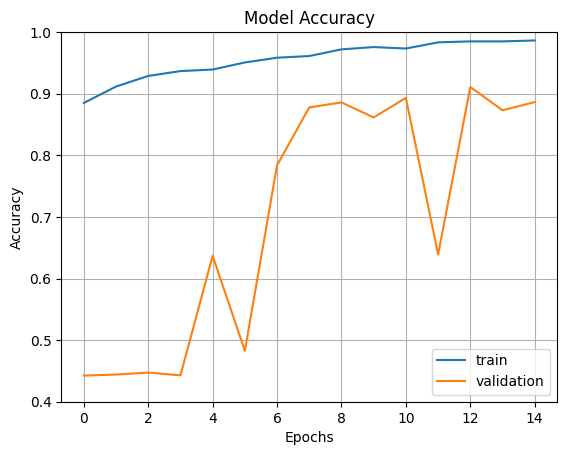

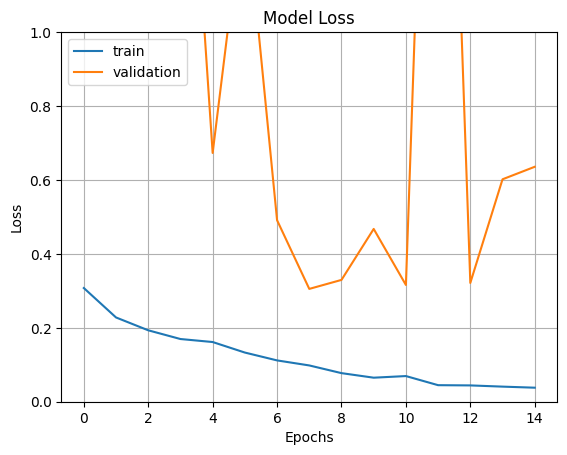

In [6]:
#for cross-validation, for this time, Set1 and Set3 is training dataset, Set2 is validation dataset
train_generator = CSET2_generator
validation_generator = SET2_generator

#build a new model, so we can evaluate the performance of our model fairly
rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/25
 70/118 [================>.............] - ETA: 14s - loss: 0.3759 - accuracy: 0.8723

2023-03-22 02:46:23.670073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 02:46:23.686597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

2023-03-22 02:46:23.886333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 128 spatial: 32 32  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 512 input_feature_map_count: 128 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-22 02:46:23.913512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an ident

118/118 [==============================] - 93s 616ms/step - loss: 0.3348 - accuracy: 0.8822 - val_loss: 0.6984 - val_accuracy: 0.4542
Epoch 2/25
118/118 [==============================] - 51s 434ms/step - loss: 0.2214 - accuracy: 0.9183 - val_loss: 3.8243 - val_accuracy: 0.4432
Epoch 3/25
118/118 [==============================] - 50s 424ms/step - loss: 0.2086 - accuracy: 0.9210 - val_loss: 2.7857 - val_accuracy: 0.4432
Epoch 4/25
118/118 [==============================] - 50s 423ms/step - loss: 0.1773 - accuracy: 0.9344 - val_loss: 0.7883 - val_accuracy: 0.4446
Epoch 5/25
118/118 [==============================] - 51s 435ms/step - loss: 0.1590 - accuracy: 0.9392 - val_loss: 1.4771 - val_accuracy: 0.4444
Epoch 6/25
118/118 [==============================] - 52s 441ms/step - loss: 0.1326 - accuracy: 0.9493 - val_loss: 2.2061 - val_accuracy: 0.4512
Epoch 7/25
118/118 [==============================] - 52s 436ms/step - loss: 0.1213 - accuracy: 0.9544 - val_loss: 1.3553 - val_accuracy: 0.5

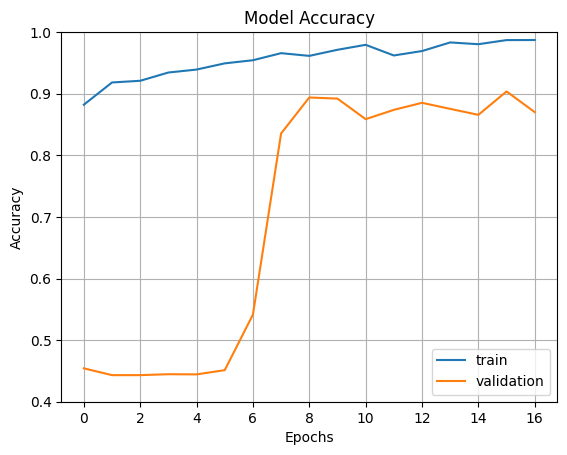

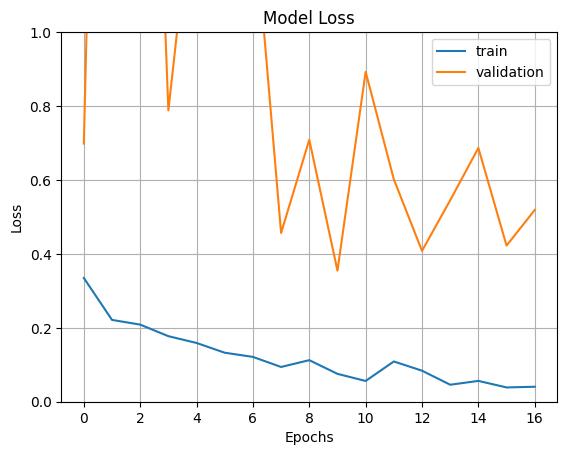

In [7]:
#for cross-validation, for this time, Set2 and Set3 is training dataset, Set1 is validation dataset
train_generator = CSET3_generator
validation_generator = SET1_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
img, _= next(test_generator)
plt.figure(figsize=(15, 13))
result = model.predict(img)
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if result[i][1] < 0.5:
        pred = 0
        if pred == _[i][1]:
            plt.title("Organic", color='green')
        else: 
            plt.title("Organic", color='red')
    else:
        pred = 1
        if pred == _[i][1]:
            plt.title("Non-Organic", color='green')
        else: 
            plt.title("Non-Organic", color='red')
    plt.axis("off")